<a href="https://colab.research.google.com/github/Pasewark/Neural-Network-Experiments/blob/master/ECE_training_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 134kB/s 
     |████████████████████████████████| 3.1MB 41.7MB/s 
     |████████████████████████████████| 501kB 58.2MB/s 


In [0]:
#resnet from https://keras.io/examples/cifar10_resnet/
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


In [0]:
# Training parameters
batch_size = 64  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:



def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [0]:
test_ece_list=np.load('test_ece_list.npy').tolist()
train_ece_list=np.load('train_ece_list.npy').tolist()

In [0]:
print(test_ece_list[1])

[       nan 0.02543121 0.03670059 0.09035782 0.06893428 0.06839215
 0.11566135 0.06117817 0.06523531 0.15779337 0.11198218 0.20601563
 0.10200115 0.12649395 0.12197527 0.14247008 0.10716674 0.13581289
 0.15214253 0.12307996 0.14903724 0.10613755 0.16749297 0.123715
 0.11930787 0.19923059 0.18565422 0.1483015  0.17797249 0.12931802
 0.11311642 0.16415836 0.13932936 0.12469658 0.15487313 0.14958523
 0.12770103 0.14007786 0.12517897 0.12683794 0.13440867 0.13115256
 0.13300387 0.14049663 0.13964269 0.12306794 0.13814767 0.13015305
 0.15601504 0.16747656 0.21442097 0.11797451 0.14429712 0.12497437
 0.17515571 0.13255208 0.14516682 0.14162301 0.14323899 0.13969963
 0.13148865 0.15471467 0.16407578 0.13129142 0.17593241 0.19987468
 0.1455832  0.13873844 0.14291244 0.14492711 0.13753977 0.15588693
 0.14426509 0.1676316  0.15300938 0.1251797  0.21524902 0.15696133
 0.13222759 0.14828459 0.1607896  0.12401479 0.11634259 0.15821093
 0.16685762 0.10916494 0.13934199 0.12490342 0.13993335 0.119223

In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
#checkpoint = ModelCheckpoint(filepath=filepath,
#                             monitor='val_acc',
#                             verbose=1,
#                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 32, 32, 16)   64          conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 32, 32, 16)   0           batch_normalization_56[0][0]     
______________________________________________________________________

In [0]:
test_ece=[]
train_ece=[]

for i in range(100):
  print('Epoch ',i)
  pred_train=model.predict(x_train)
  e_train=ECE(pred_train,y_train)
  print(e_train)
  train_ece.append(e_train)
  pred=model.predict(x_test)
  e=ECE(pred,y_test)
  print(e)
  test_ece.append(e)
  model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch  0
nan
nan
Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 105s 2ms/sample - loss: 1.8399 - accuracy: 0.5086 - val_loss: 1.8739 - val_accuracy: 0.4933
Epoch  1
0.137509228515625
0.1492532958984375
Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.3255 - accuracy: 0.6605 - val_loss: 1.4073 - val_accuracy: 0.6325
Epoch  2
0.038089765625
0.057583349609375
Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 95s 2ms/sample - loss: 1.1195 - accuracy: 0.7239 - val_loss: 1.2016 - val_accuracy: 0.6928
Epoch  3
0.013518360595703126
0.0324651123046875
Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 95s 2ms/sample - loss: 0.9879 - accuracy: 0.7651 - val_loss: 1.2025 - val_accuracy: 0.7055
Epoch  4
0.02373697509765625
0.068704248046875
Train on 50000 samples, validate on 10000 samp

In [0]:
print(len(test_ece))
print(len(np.mean(test_ece_list,axis=0)))

100
100


In [0]:
test_ece_list.append(test_ece)
train_ece_list.append(train_ece)

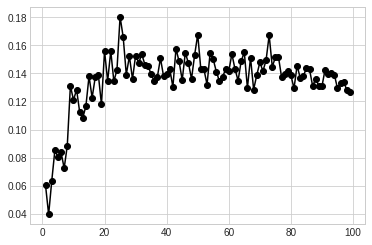

In [0]:
plt.plot(range(1,100), np.nanmean(test_ece_list,axis=0)[1:], '-ok');


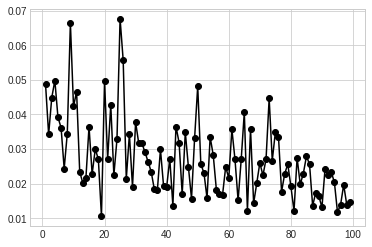

In [0]:
plt.plot(range(1,100), np.nanmean(train_ece_list,axis=0)[1:], '-ok');


In [0]:
np.save('test_ece_list',np.array(test_ece_list))
np.save('train_ece_list',np.array(train_ece_list))

In [0]:
!ls ..

bin	 datalab  home	 lib64	opt   run   swift		tmp    var
boot	 dev	  lib	 media	proc  sbin  sys			tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0b1	usr


In [0]:


#callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

W0823 04:08:32.034775 139983337224064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 64s 1ms/sample - loss: 1.8356 - accuracy: 0.5094 - val_loss: 1.5700 - val_accuracy: 0.5896
Epoch 2/200
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.3309 - accuracy: 0.6582 - val_loss: 1.4799 - val_accuracy: 0.5951
Epoch 3/200
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.1114 - accuracy: 0.7254 - val_loss: 1.3418 - val_accuracy: 0.6671
Epoch 4/200
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.9785 - accuracy: 0.7675 - val_loss: 1.1943 - val_accuracy: 0.6923
Epoch 5/200
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.8877 - accuracy: 0.7963 - val_loss: 1.2010 - val_accuracy: 0.6915
Epoch 6/200
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.8152 - accuracy: 0.8210 - val_loss: 1.2800 - val_accuracy: 0.6758
Epoch 7/200
50000/50000 [=========================

KeyboardInterrupt: ignored

In [0]:
def ECE_correct(probs,correct):
  #correct are 0 or 1 for incorrect or correct prediction
  #probs are highest prob for each example
  #probably also want to look at more than just highest later and see how good those are too
  #tf.print(probs.shape,correct.shape)
  #start with 10 bins
  num_bins=50
  inds=tf.argsort(probs,axis=-1)
  probs=tf.gather(probs,inds)
  correct=tf.gather(correct,inds)
  #tf.print('probs',probs)
  #tf.print('correct',correct)
  inds=[]
  current=int(num_bins*.3)
  for i in range(len(probs)):
    if probs[i]>current/float(num_bins):
      inds.append(i)
      current+=1
      #print(current)
      #print(probs[i])
    if current==num_bins: break
      
  #print('inds',inds)
  sizes=[]
  total=0
  for i in range(len(inds)):
    if i==0: sizes.append(inds[i])
    else: sizes.append(inds[i]-inds[i-1])
  sizes.append(len(probs)-inds[-1])
  
  #print('sizes',sizes)
      
  prob_splits=tf.split(probs,sizes)
  correct_splits=tf.split(correct,sizes)
  #tf.print('prob_splits[0]',prob_splits[0])
  #tf.print('correct_splits[0]',correct_splits[0])
  
  mean_probs=[tf.reduce_mean(split) for split in prob_splits]
  mean_acc=[tf.reduce_mean(split) for split in correct_splits]
  
  #tf.print('mean_probs',mean_probs)
  #tf.print('mean_acc',mean_acc)
  #tf.print(mean_acc[0])
  #a=mean_acc[0]-mean_probs[0]
  
  weighted_errors=[sizes[i]*abs(mean_acc[i]-mean_probs[i]) for i in range(len(sizes))]
  
  ece=np.sum(weighted_errors)/float(len(probs))
  return ece

def ECE(pred,y_test):
  #input are raw probabilities and test data
  max_probs=pred[np.arange(len(pred)),np.argmax(pred,axis=-1)]
  classes=np.argmax(y_test,axis=-1)
  correct=np.equal(np.argmax(pred,axis=-1),classes)
  return ECE_correct(tf.cast(max_probs,tf.float32),tf.cast(correct,tf.float32))

In [0]:
pred=model.predict(x_test)
print(model.evaluate(x_test,y_test))

10000/10000 [==============================] - 4s 395us/sample - loss: 1.4152 - accuracy: 0.7629
[1.4152463618278504, 0.7629]


In [0]:
print(np.argmax(pred,axis=-1)[:20])
print(pred[np.arange(len(pred)),np.argmax(pred,axis=-1)][:20])

[3 1 1 1 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
[0.89591116 0.99982846 0.7993118  0.53371274 0.99942756 0.9002451
 0.9999968  0.8814435  0.9995988  0.99999356 0.9999893  1.
 0.9835624  0.9999808  0.9999912  0.84776574 0.99999905 0.5998045
 0.9687728  1.        ]


In [0]:
print(np.argmax(y_test,axis=-1)[:20])

[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]


In [0]:
print(np.equal(np.argmax(pred,axis=-1),np.argmax(y_test,axis=-1))[:20])

[ True False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [0]:
np.mean((np.equal(np.argmax(pred,axis=-1),np.argmax(y_test,axis=-1))))

0.7629

In [0]:
ECE(pred,y_test)

TensorShape([10000]) TensorShape([10000])
probs [0.253340214 0.26166755 0.273774981 ... 1 1 1]
correct [0 0 0 ... 1 1 1]
4
tf.Tensor(0.30788773, shape=(), dtype=float32)
5
tf.Tensor(0.40141052, shape=(), dtype=float32)
6
tf.Tensor(0.5002312, shape=(), dtype=float32)
7
tf.Tensor(0.60030997, shape=(), dtype=float32)
8
tf.Tensor(0.7002798, shape=(), dtype=float32)
9
tf.Tensor(0.8001268, shape=(), dtype=float32)
10
tf.Tensor(0.9002451, shape=(), dtype=float32)
inds [6, 64, 271, 761, 1201, 1775, 2507]
sizes [6, 58, 207, 490, 440, 574, 732, 7493]
prob_splits[0] [0.253340214 0.26166755 0.273774981 0.288490653 0.291321278 0.299973071]
correct_splits[0] [0 0 0 0 0 0]
mean_probs [0.27809462, 0.369045496, 0.457514673, 0.549990773, 0.651206672, 0.751099288, 0.852908432, 0.98860693]
mean_acc [0, 0.310344815, 0.299516916, 0.397959173, 0.436363637, 0.484320551, 0.558743179, 0.864139855]


0.1507896728515625

In [0]:
pred_train=model.predict(x_train)

In [0]:
ECE(pred_train,y_train)

TensorShape([50000]) TensorShape([50000])
probs [0.256432384 0.2702142 0.273556948 ... 1 1 1]
correct [0 0 0 ... 1 1 1]
4
tf.Tensor(0.3006269, shape=(), dtype=float32)
5
tf.Tensor(0.40010098, shape=(), dtype=float32)
6
tf.Tensor(0.5000226, shape=(), dtype=float32)
7
tf.Tensor(0.6000785, shape=(), dtype=float32)
8
tf.Tensor(0.7000573, shape=(), dtype=float32)
9
tf.Tensor(0.8002266, shape=(), dtype=float32)
10
tf.Tensor(0.90001076, shape=(), dtype=float32)
inds [12, 195, 813, 2272, 3830, 5737, 8531]
sizes [12, 183, 618, 1459, 1558, 1907, 2794, 41469]
prob_splits[0] [0.256432384 0.2702142 0.273556948 ... 0.294359118 0.295161813 0.298843801]
correct_splits[0] [0 0 0 ... 0 0 0]
mean_probs [0.282539815, 0.361180365, 0.461114734, 0.548832834, 0.651640773, 0.751428604, 0.854699373, 0.99107]
mean_acc [0.0833333358, 0.360655725, 0.41747573, 0.502398908, 0.579589188, 0.65600419, 0.739799559, 0.971810281]


0.03022286865234375

In [0]:
ECE(pred,y_test)

TensorShape([10000]) TensorShape([10000])
probs [0.253340214 0.26166755 0.273774981 ... 1 1 1]
correct [0 0 0 ... 1 1 1]
16
tf.Tensor(0.30788773, shape=(), dtype=float32)
17
tf.Tensor(0.3206472, shape=(), dtype=float32)
18
tf.Tensor(0.34165972, shape=(), dtype=float32)
19
tf.Tensor(0.36061415, shape=(), dtype=float32)
20
tf.Tensor(0.380566, shape=(), dtype=float32)
21
tf.Tensor(0.40141052, shape=(), dtype=float32)
22
tf.Tensor(0.420108, shape=(), dtype=float32)
23
tf.Tensor(0.4407618, shape=(), dtype=float32)
24
tf.Tensor(0.460407, shape=(), dtype=float32)
25
tf.Tensor(0.4804753, shape=(), dtype=float32)
26
tf.Tensor(0.5002312, shape=(), dtype=float32)
27
tf.Tensor(0.52020264, shape=(), dtype=float32)
28
tf.Tensor(0.54000777, shape=(), dtype=float32)
29
tf.Tensor(0.56040895, shape=(), dtype=float32)
30
tf.Tensor(0.5801127, shape=(), dtype=float32)
31
tf.Tensor(0.60030997, shape=(), dtype=float32)
32
tf.Tensor(0.6202526, shape=(), dtype=float32)
33
tf.Tensor(0.6401434, shape=(), dtype=f

0.15115433349609375

In [0]:
ECE(pred_train,y_train)

TensorShape([50000]) TensorShape([50000])
probs [0.256432384 0.2702142 0.273556948 ... 1 1 1]
correct [0 0 0 ... 1 1 1]
16
tf.Tensor(0.3006269, shape=(), dtype=float32)
17
tf.Tensor(0.32022187, shape=(), dtype=float32)
18
tf.Tensor(0.34013262, shape=(), dtype=float32)
19
tf.Tensor(0.36025882, shape=(), dtype=float32)
20
tf.Tensor(0.3801027, shape=(), dtype=float32)
21
tf.Tensor(0.40010098, shape=(), dtype=float32)
22
tf.Tensor(0.42011607, shape=(), dtype=float32)
23
tf.Tensor(0.44037503, shape=(), dtype=float32)
24
tf.Tensor(0.46059698, shape=(), dtype=float32)
25
tf.Tensor(0.4802546, shape=(), dtype=float32)
26
tf.Tensor(0.5000226, shape=(), dtype=float32)
27
tf.Tensor(0.5200013, shape=(), dtype=float32)
28
tf.Tensor(0.5400108, shape=(), dtype=float32)
29
tf.Tensor(0.5600885, shape=(), dtype=float32)
30
tf.Tensor(0.5800142, shape=(), dtype=float32)
31
tf.Tensor(0.6000785, shape=(), dtype=float32)
32
tf.Tensor(0.62001616, shape=(), dtype=float32)
33
tf.Tensor(0.64005387, shape=(), dtyp

0.03049845947265625